This notebook calculate the sedimentation amount of 230Th. 

Formula:

    sedimentation = Th conc. in the last layer * sinking rate * dx * dy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from ArcticTools import map
%matplotlib inline

In [2]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/Tochum/EXP00/mesh_mask.nc')
tmask= mesh.variables['tmask'][0,:,400:,:]
e2t  = mesh.variables['e2t'][0,400:,:]
e1t  = mesh.variables['e1t'][0,400:,:]
mbathy=mesh.variables['mbathy'][0,400:,:]

In [3]:
nclist=['/ocean/xiaoxiny/research/result_jasper/data_exh005_bt/EXH005-bt_19912016.nc',
       # '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav/EXH005-btscav_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2/EXH005-btscav_v2_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2_cv/EXH005-btscav2_cv_19912015.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2_cs/EXH005-btscav2_cs_19912016.nc'
       ]

In [4]:
xp = nc.Dataset(nclist[1]).variables['TR_10'][:]
ice3d = nc.Dataset(nclist[1]).variables['TR_12'][:]

In [5]:
def sedimentation(Th_conc,sinking,dx,dy):
    sed = Th_conc*sinking*dx*dy
    return sed

In [6]:
def sinking(ice):
    '''note that this s should be the regulated s, as the layer is hitting the sea floor.
    Ice has to ba an float only (list is not going to work)'''
    
    s1 = -986.96*ice+1456.45
    s2 = (3*(1-ice)+1)*s1
    s = np.min([s1,s2])
    return s

Visualize the differences in Th between the interested year and 2002

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


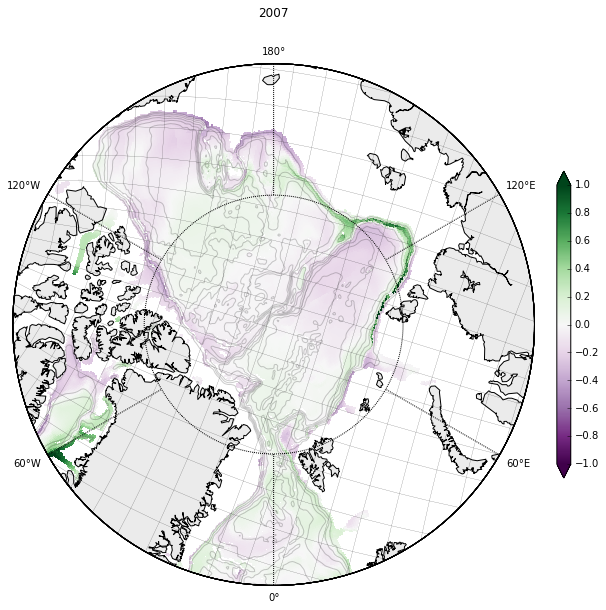

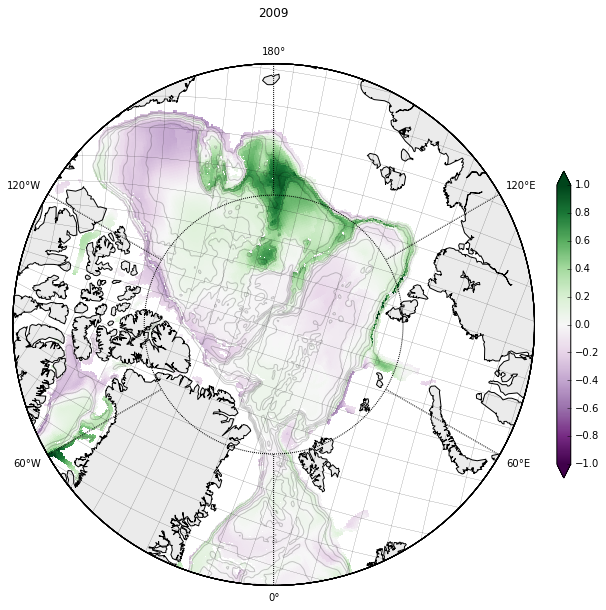

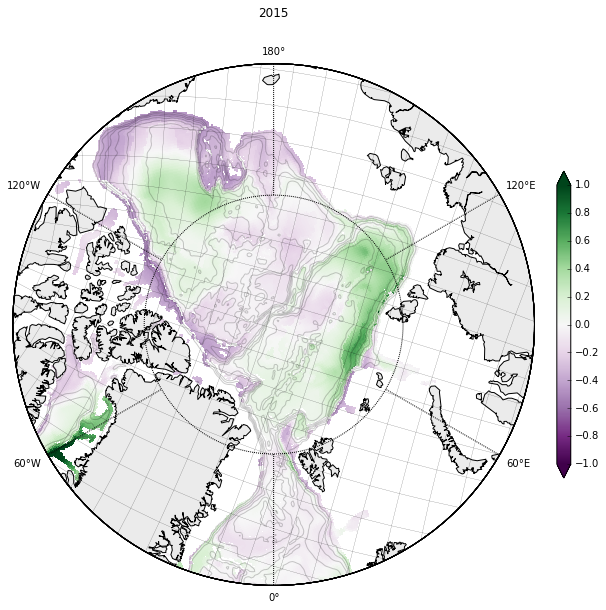

In [7]:
for year in [2007,2009,2015]:
    sed = np.zeros_like(e1t);sed0 = np.zeros_like(e1t)
    for i in range(len(e1t[:,0])):
        for j in range(len(e1t[0,:])):
            dep = mbathy[i,j]-1
            
            ice0 = ice3d[year-1991,dep,i,j]
            s0 = sinking(ice0)
            sed0[i,j]= sedimentation(xp[year-1991,dep,i,j],s0,e1t[i,j],e2t[i,j])
            
            
            ice = ice3d[year-1991,dep,i,j]
            s = sinking(ice)
            sed[i,j]= (sedimentation(xp[year-1991,dep,i,j],s,e1t[i,j],e2t[i,j])\
                    - sedimentation(xp[2002-1991,dep,i,j],s0,e1t[i,j],e2t[i,j]))\
                    /sedimentation(xp[2002-1991,dep,i,j],s0,e1t[i,j],e2t[i,j])
    #mask < 500 m
    sed[mbathy < 30]=np.nan
    #plot
    f,ax = plt.subplots(1,figsize = (10,10))
    m,x_lon,y_lat=map.mapping(70)#maponCB(ax)
    cs = m.pcolor(x_lon[:],y_lat[:],np.ma.masked_invalid(sed[:,:]),\
                           cmap='PRGn',vmax=1,vmin=-1)
    plt.colorbar(cs,ax=ax,fraction=0.025, pad=0.04,extend='both');plt.title(year,y=1.08)
    plt.show()

In order to figure out what's the reason for the changes in sedimentation rate, visualize the 'ice'. Make the Th plots and the ice plots side by side

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in float_scalars


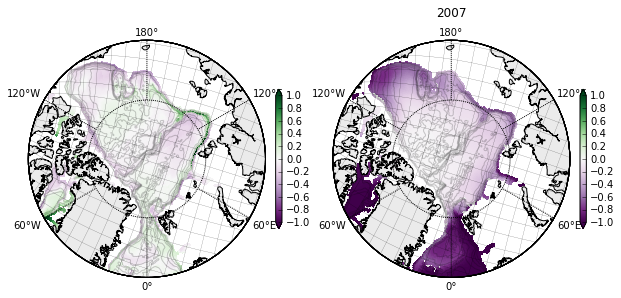

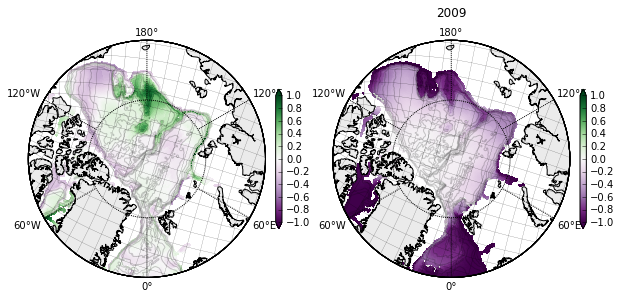

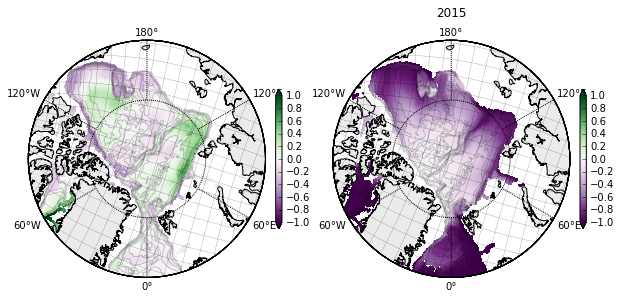

In [8]:
for year in [2007,2009,2015]:
    sed = np.zeros_like(e1t);sed0 =np.zeros_like(e1t);diagnose_ice = np.zeros_like(e1t)
    for i in range(len(e1t[:,0])):
        for j in range(len(e1t[0,:])):
            dep = mbathy[i,j]-1
            # sed
            ice0 = ice3d[year-1991,dep,i,j]
            s0 = sinking(ice0)
            sed0[i,j]= sedimentation(xp[year-1991,dep,i,j],s0,e1t[i,j],e2t[i,j])
            
            ice = ice3d[year-1991,dep,i,j]
            s = sinking(ice)
            sed[i,j]= (sedimentation(xp[year-1991,dep,i,j],s,e1t[i,j],e2t[i,j])\
                    - sedimentation(xp[2002-1991,dep,i,j],s0,e1t[i,j],e2t[i,j]))\
                    /sedimentation(xp[2002-1991,dep,i,j],s0,e1t[i,j],e2t[i,j])
            # ice    
            diagnose_ice[i,j]= (ice3d[year-1991,dep,i,j]\
                            - ice3d[2002-1991,dep,i,j]\
                            /ice3d[2002-1991,dep,i,j])    
    
    f,axes = plt.subplots(1,2,figsize = (10,10))
    for data,ax in zip ([sed,diagnose_ice],[axes[0],axes[1]]):        
        #mask < 500 m
        data[mbathy < 30]=np.nan
        #plot
        m,x_lon,y_lat=map.mapping(70,ax=ax)#maponCB(ax)
        cs = m.pcolor(x_lon[:],y_lat[:],np.ma.masked_invalid(data[:,:]),\
                               cmap='PRGn',vmax=1,vmin=-1)
        plt.colorbar(cs,ax=ax,fraction=0.025, pad=0.04,extend='both');plt.title(year,y=1.08)
    plt.show()

# Calculated correlation coeff.

between sea ice time series and Th time series

In [11]:
# gather information
sed = np.zeros_like(xp[:,0,...]);sed0 = np.zeros_like(sed);
diagnose_ice = np.zeros_like(sed);corrcoeff = np.zeros_like(e1t)
    
for year in range (xp.shape[0]-1):
    year = year + 1991
    for i in range(len(e1t[:,0])):
        for j in range(len(e1t[0,:])):
            dep = mbathy[i,j]-1
            # sed
            ice0 = ice3d[year-1991,dep,i,j]
            s0 = sinking(ice0)
            sed0[year-1991,i,j]= sedimentation(xp[year-1991,dep,i,j],s0,e1t[i,j],e2t[i,j])
            
            ice = ice3d[year-1991,dep,i,j]
            s = sinking(ice)
            sed[year-1991,i,j]= (sedimentation(xp[year-1991,dep,i,j],s,e1t[i,j],e2t[i,j])\
                    - sedimentation(xp[2002-1991,dep,i,j],s0,e1t[i,j],e2t[i,j]))\
                    /sedimentation(xp[2002-1991,dep,i,j],s0,e1t[i,j],e2t[i,j])
            # ice    
            diagnose_ice[year-1991,i,j]= (ice3d[year-1991,dep,i,j]\
                            - ice3d[2002-1991,dep,i,j])

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


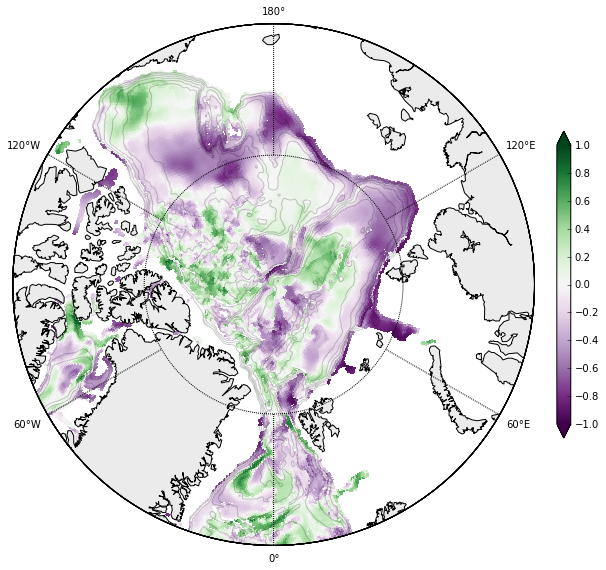

In [12]:
# calculate correlation coeff. between sea ice and change of Th
layer0 = 0
ice0 = ice3d[:,layer0,:,:] - ice3d[11,layer0,:,:]
for i in range(len(e1t[:,0])):
    for j in range(len(e1t[0,:])):
        corrcoeff[i,j] = np.corrcoef(sed[11:,i,j], ice0[11:,i,j])[0,1]
# plot        
f,axes = plt.subplots(1,figsize = (10,10))
for data,ax in zip ([corrcoeff],[axes]):        
    # mask < 500 m
    data[mbathy < 30]=np.nan
    m,x_lon,y_lat=map.mapping(70,ax=ax,Gridkey=False)#maponCB(ax)
    cs = m.pcolor(x_lon[:],y_lat[:],np.ma.masked_invalid(data[:,:]),\
                           cmap='PRGn',vmax=1,vmin=-1)
    plt.colorbar(cs,ax=ax,fraction=0.025, pad=0.04,extend='both');
plt.show()